# q3dfit notebook: rest-frame optical, JWST/NIRSpec data of J1652 (SDSSJ165202.64+172852.3) from [Wylezalek et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221010074W/abstract)

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://q3d.github.io/) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Initializing the fit](#chapter1_1)
    * [1.2. Setting up the data and models](#chapter1_2)
    * [1.3. Setting up the fitting parameters](#chapter1_3)
        * [1.3.1. Emission line parameters](#chapter1_3_1)
        * [1.3.2. Continuum parameters](#chapter1_3_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
#import sys
#sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'nirspec-j1652/'
# prefix label for output files
label = 'j1652'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder:

In [4]:
# make tuples of urls and download filenames
# infile = data cube
infile_tup=('https://rhodes.box.com/shared/static/scu2ydokah2wcqtfsh1tg2y76m75b91q.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
from q3dfit.jnb import download_files
infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
infile = initdir+infile

nirspec-j1652.fits already exists, skipping download...


### 1.1. Initializing the fit <a class="anchor" id="chapter1_1"></a>

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [5]:
from q3dfit.q3din import q3din
q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [6]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': 'nirspec-j1652/nirspec-j1652.fits',
 'fitrange': None,
 'label': 'j1652',
 'logfile': 'nirspec-j1652/j1652-fitlog.txt',
 'name': None,
 'outdir': 'nirspec-j1652/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 0,
 'varext': 1,
 'dqext': 2,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models <a class="anchor" id="chapter1_2"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.

In [7]:
q3di.argsreadcube = {'wmapext': None,
                     'fluxunit_in': 'erg/s/cm2/Angstrom'}
cube = q3di.load_cube()

Cube: No wavelength units in header; using micron
Cube: No flux units in header; using erg/s/cm2/Angstrom
Cube: No pixel area in header or specified in call; no correction for surface brightness flux units.
Size of data cube: [ 86 , 77 , 700 ]
Wavelength range: [ 1.8184203 , 2.0952241 ]  micron
Input flux units:  erg/s/cm2/Angstrom
Input wave units:  micron
Output flux units:  erg/s/cm2/micron
Output wave units:  micron
NB: q3dfit uses output units for internal calculations.


Let's plot a spaxel near the quasar to see how it looks. The arguments are column and row in unity-offset units. Specifying `radius=0` selects a single spaxel; specifying `radius` > 0 spaxels extracts flux in a circular aperture using `photutils`. This is the region of the galaxy's spectrum containing H$\beta$ and [OIII] 4959, 5007 Å. The flux units are erg/s/cm$^2$/$\mu$m.

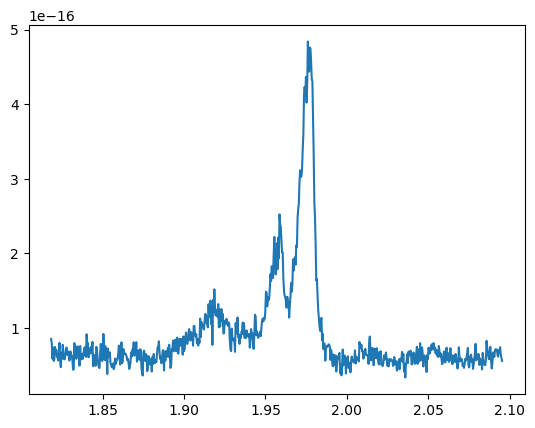

In [8]:
spec_test = cube.specextract(48, 48, radius=0)

Due to the fact that JWST/NIRSpec undersamples the PSF, bright point sources create undulations in the spectrum. We apply light smoothing with a circular aperture of radius 2.5 spaxels to account for this, and then plot the result.

In [9]:
cube.convolve(2.5)

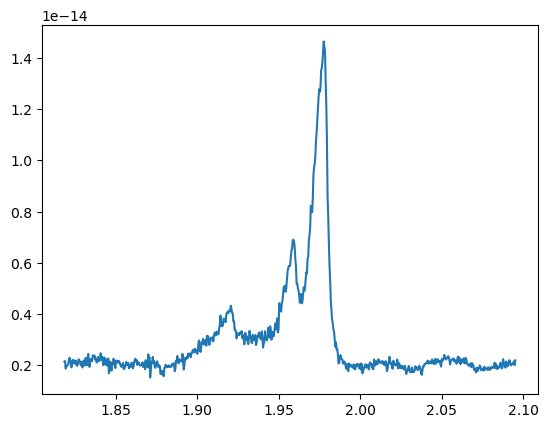

In [10]:
spec_conv = cube.specextract(48, 48, radius=0)

Now we'll write this convolved cube to disk, and redefine it as our input file for the fit.

In [11]:
cube.writefits(initdir+'nirspec-j1652-conv.fits')
q3di.infile = initdir+'nirspec-j1652-conv.fits'

This time, we are going to normalize to minimize numerical issues in the fitting.

In [12]:
q3di.argsreadcube = {'wmapext': None, 
                     'fluxunit_in': 'erg/s/cm2/micron',
                     'fluxnorm': 1e-17}
cube = q3di.load_cube()

Cube: No wavelength units in header; using micron
Cube: No flux units in header; using erg/s/cm2/micron
Cube: No pixel area in header or specified in call; no correction for surface brightness flux units.
Size of data cube: [ 86 , 77 , 700 ]
Wavelength range: [ 1.8184203 , 2.0952241 ]  micron
Input flux units:  erg/s/cm2/micron
Input wave units:  micron
Output flux units:  erg/s/cm2/micron
Output wave units:  micron
NB: q3dfit uses output units for internal calculations.


Let's double-check what we have:

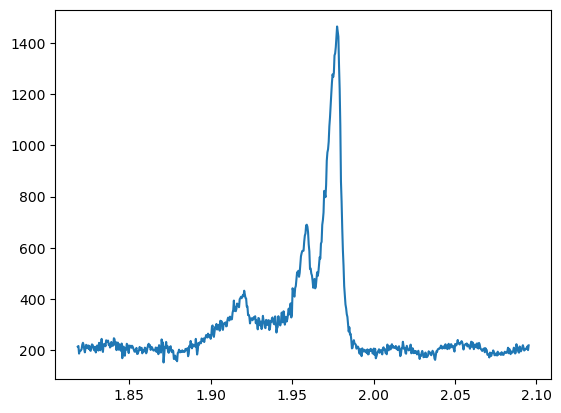

In [13]:
spec_test = cube.specextract(48, 48, radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below.

In [14]:
q3di.name = 'J1652'
q3di.zsys_gas = 2.9489

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [15]:
q3di.fitrange = [1.82, 2.09]
#q3di.cutrange = np.array([,])

Create quasar template from the peak spaxel. We normalize so the template flux is around unity.

makeqsotempate: using peak spaxel in white light as center


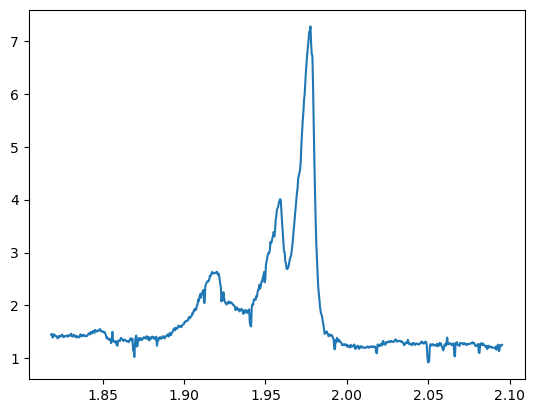

In [16]:
qsotemplate = outdir+'nirspec-j1652-quasar-template.npy'
cube.makeqsotemplate(qsotemplate, radius=0., norm=5e3)

### 1.3. Setting up the fitting parameters <a class="anchor" id="chapter1_3"></a>

#### 1.3.1. Emission-line parameters <a class="anchor" id="chapter1_3_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/q3dfit/data/linelists), or in `q3dfit/data/linelists/`.

In [17]:
lines = ['Hbeta', '[OIII]4959', '[OIII]5007']

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1. Here, we change this to 3.

In [18]:
q3di.init_linefit(lines, linetie='[OIII]5007', maxncomp=3)
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'perror_errspecwin', 'perror_residwin', 'perror_useresid', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas'])

Because of the complexity of these line profiles, we change the default initial conditions. `zinit_gas` and `siginit_gas` are dictionaries of arrays that hold the initial conditions for each line, spaxel, and velocity component.

In [19]:
for i in lines:
    # narrow, redshifted component
    q3di.zinit_gas[i][:,:,2] = 2.959
    # broad, blueshifted component
    q3di.zinit_gas[i][:,:,1] = 2.9489
    q3di.siginit_gas[i][:,:,1] = 500.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [20]:
# Global limit
q3di.siglim_gas = np.array([40., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run. The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut. Component checking can be disabled by setting `checkcomp = False`.

In [21]:
#q3di.checkcomp = False
q3di.argscheckcomp['sigcut'] = 3.
q3di.argscheckcomp['ignore']= ['Hbeta']

#### Line ratio constraints
Lines with ratios fixed by atomic physics have their ratios fixed automatically. Other line ratios can have bound constraints applied, or they can be fixed to a particular value.

`line1`, `line2`, and `comp` are required. `comp` is an array of velocity components (zero-indexed) on which to apply the constraints, one array for each pair of lines.

`value` is the initial value of `line1`/`line2`. Presently, if `value` is specified for one pair of lines, it must be specified for all. Otherwise, the initial value is determined from the data.

The ratio can be `fixed` to the initial value. Presently, if `fixed` is defined, it must be set to `True` or `False` for all pairs of line.

If the ratio is not `fixed`, `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) Presently, if `lower` or `upper` is defined here for one set of lines, it must be defined here for every pair of lines.

In [22]:
# Required columns:
# line1 = ['[NI]5198', '[SII]6716']
# line2 = ['[NI]5200', '[SII]6731']
# comp = np.array([[0], [0]], dtype=np.int32)

# Optional columns:
# value = [1.5, 1.]
# fixed = [True, False]
# lower = []
# upper = []

# Write table
# from astropy.table import QTable
# lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

# q3di.argslineinit['lineratio']=lineratio

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

This case applies to the GMOS B600 grating. Gemini website says R = 1688 at 4610 A for 0.5" slit, with IFU 0.31" eff. slit. This gives 1.69 A FWHM. I measure sometimes closer to 1.5-1.6 A.

In [23]:
spect_instrum = {'JWST_NIRSPEC':['G235H']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [24]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares` (or `scipy.optimize.leastsq`, or other optimizer)
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html), or another method of choice. Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `method`: in particular, `leastsq` may be faster than `least_squares`
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares`/`leastsq` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`
- `epsfcn`

In [25]:
#q3di.argslinefit['method'] = 'leastsq'
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-15:
#q3di.argslinefit['ftol'] = 1.e-10
#q3di.argslinefit['gtol'] = 1.e-10
#q3di.argslinefit['xtol'] = 1.e-10
# .. and the "suitable step length for the forward- difference approximation of the Jacobian. Normally the actual step length will be sqrt(epsfcn)*x"
# this is only for scipy.optimize.leastsq
#q3di.argslinefit['epsfcn'] = 1.e-15

#### 1.3.2 Continuum parameters <a class="anchor" id="chapter1_3_2"></a>

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [26]:
q3di.init_contfit('fitqsohost')
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'perror_errspecwin', 'perror_residwin', 'perror_useresid', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'argsconvtemp', 'decompose_qso_fit', 'decompose_ppxf_fit', 'dividecont', 'ebv_star', 'fcnconvtemp', 'forcefloat64', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'tweakcntfit', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. The default mask value is 500 km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

For this case, the lines are quite broad and we change the default.

In [27]:
q3di.maskwidths_def = 2000.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

In [28]:
q3di.argscontfit['qsoxdr'] = qsotemplate
q3di.argscontfit['qsoord'] = 2
q3di.argscontfit['hostord'] = 2
q3di.decompose_qso_fit = True

Optional arguments to `lmfit`. See above for a description in the case of line fits.

In [29]:
#q3di.argscontfit['method'] = 'leastsq'

argslmfit = dict()
argslmfit['ftol'] = 1.e-15
argslmfit['gtol'] = 1.e-15
argslmfit['xtol'] = 1.e-15
#argslmfit['epsfcn'] = 1.e-10

q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [30]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [31]:
cols = 45
rows = 29

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [32]:
from q3dfit.q3df import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

Core 1: # spaxels fit=1
[col,row]=[45,29] out of [86,77]
FITLOOP: First call to FITSPEC
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5978e+04                                    1.55e+03    
       1              2         1.5978e+04      3.34e-02       1.00e-05       1.55e+03    
       2              3         1.5978e+04      6.69e-02       2.00e-05       1.55e+03    
       3              4         1.5977e+04      1.34e-01       4.00e-05       1.55e+03    
       4              5         1.5977e+04      2.68e-01       8.00e-05       1.55e+03    
       5              6         1.5977e+04      5.35e-01       1.60e-04       1.55e+03    
       6              7         1.5976e+04      1.07e+00       3.20e-04       1.55e+03    
       7              8         1.5973e+04      2.14e+00       6.40e-04       1.55e+03    
       8              9         1.5969e+04      4.28e+00       1.28e-03       1.55e+03    
  

      93             115        1.3128e+03      1.49e-05       1.99e-03       7.41e-04    
      94             116        1.3128e+03      2.25e-05       5.59e-03       4.09e-03    
      95             118        1.3128e+03      1.02e-05       4.12e-03       4.63e-03    
      96             119        1.3128e+03      9.97e-06       3.46e-03       2.58e-03    
      97             121        1.3128e+03      3.77e-06       2.88e-03       2.82e-03    
      98             122        1.3128e+03      4.68e-06       1.86e-03       3.49e-03    
      99             123        1.3128e+03      8.71e-06       3.36e-03       1.04e-03    
      100            124        1.3128e+03      9.97e-06       8.74e-03       4.35e-03    
      101            126        1.3128e+03      5.37e-06       3.81e-03       3.40e-03    
      102            127        1.3128e+03      3.30e-06       1.94e-03       1.12e-03    
      103            128        1.3128e+03      3.62e-06       5.57e-03       3.69e-03    

      190            227        1.3128e+03      1.28e-06       2.51e-03       6.50e-04    
      191            229        1.3128e+03      3.38e-06       8.16e-03       2.20e-03    
      192            231        1.3128e+03      1.53e-06       2.06e-03       4.64e-03    
      193            232        1.3128e+03      1.23e-06       2.05e-03       6.45e-04    
      194            233        1.3128e+03      1.75e-06       4.26e-03       1.40e-03    
      195            234        1.3128e+03      1.19e-06       1.95e-03       1.45e-03    
      196            235        1.3128e+03      5.17e-07       8.97e-04       1.10e-03    
      197            236        1.3128e+03      2.20e-06       4.16e-03       6.93e-04    
      198            238        1.3128e+03      4.61e-07       9.98e-04       6.47e-04    
      199            239        1.3128e+03      5.83e-07       1.09e-03       6.79e-04    
      200            240        1.3128e+03      1.93e-07       3.56e-04       6.77e-04    

      281            331        1.3128e+03      1.06e-06       1.99e-03       6.09e-04    
      282            332        1.3128e+03      2.12e-06       3.94e-03       6.11e-04    
      283            333        1.3128e+03      3.98e-06       8.20e-03       1.17e-03    
      284            335        1.3128e+03      1.30e-06       3.69e-03       2.25e-03    
      285            337        1.3128e+03      8.00e-07       1.12e-03       9.11e-04    
      286            338        1.3128e+03      4.68e-07       8.08e-04       6.31e-04    
      287            339        1.3128e+03      5.30e-07       1.00e-03       6.17e-04    
      288            340        1.3128e+03      1.06e-06       2.00e-03       6.03e-04    
      289            341        1.3128e+03      2.12e-06       4.00e-03       6.08e-04    
      290            342        1.3128e+03      3.12e-06       5.91e-03       6.03e-04    
      291            343        1.3128e+03      4.22e-06       8.01e-03       6.00e-04    

      373            433        1.3128e+03      9.37e-07       1.83e-03       5.97e-04    
      374            434        1.3128e+03      1.21e-06       2.38e-03       6.20e-04    
      375            435        1.3128e+03      9.85e-07       1.91e-03       6.13e-04    
      376            436        1.3128e+03      2.41e-06       4.70e-03       5.95e-04    
      377            437        1.3128e+03      4.67e-06       9.31e-03       8.14e-04    
      378            438        1.3128e+03      7.96e-07       1.47e-03       5.86e-04    
      379            439        1.3128e+03      9.59e-06       1.86e-02       6.39e-04    
      380            440        1.3128e+03      1.50e-06       3.18e-03       6.14e-04    
      381            441        1.3128e+03      5.11e-07       9.09e-04       6.13e-04    
      382            442        1.3128e+03      1.38e-05       3.71e-02       5.53e-03    
      383            444        1.3128e+03      4.70e-06       2.74e-03       1.04e-02    

      468            536        1.3128e+03      3.30e-06       1.02e-02       2.62e-03    
      469            538        1.3128e+03      2.11e-06       2.36e-03       6.19e-03    
      470            539        1.3128e+03      1.31e-06       2.55e-03       8.95e-04    
      471            541        1.3128e+03      4.67e-07       1.44e-03       1.10e-03    
      472            542        1.3128e+03      4.65e-07       8.21e-04       7.20e-04    
      473            543        1.3128e+03      6.16e-07       1.30e-03       5.69e-04    
      474            544        1.3128e+03      8.39e-07       2.68e-03       1.35e-03    
      475            545        1.3128e+03      7.42e-07       1.13e-03       1.12e-03    
      476            546        1.3128e+03      4.75e-07       1.07e-03       8.36e-04    
      477            547        1.3128e+03      1.90e-07       3.73e-04       6.68e-04    
      478            548        1.3128e+03      5.73e-07       1.13e-03       5.69e-04    

      564            640        1.3128e+03      2.87e-06       5.91e-03       5.56e-04    
      565            641        1.3128e+03      1.44e-06       1.16e-02       4.00e-03    
      566            642        1.3128e+03      4.05e-06       3.64e-03       3.13e-03    
      567            643        1.3128e+03      1.30e-06       2.63e-03       1.54e-03    
      568            645        1.3128e+03      4.20e-07       8.55e-04       7.87e-04    
      569            646        1.3128e+03      3.76e-07       7.81e-04       6.52e-04    
      570            647        1.3128e+03      7.30e-07       1.53e-03       6.11e-04    
      571            648        1.3128e+03      5.21e-07       1.05e-03       5.96e-04    
      572            649        1.3128e+03      1.46e-06       2.95e-03       5.59e-04    
      573            650        1.3128e+03      6.67e-07       1.35e-03       5.59e-04    
      574            651        1.3128e+03      2.31e-06       4.67e-03       5.62e-04    

      663            746        1.3128e+03      7.81e-07       1.65e-03       5.85e-04    
      664            747        1.3128e+03      8.26e-07       1.71e-03       5.96e-04    
      665            748        1.3128e+03      1.05e-06       3.43e-03       1.43e-03    
      666            749        1.3128e+03      1.11e-06       2.61e-03       2.81e-03    
      667            751        1.3128e+03      3.97e-07       6.44e-04       6.13e-04    
      668            752        1.3128e+03      3.13e-07       5.69e-04       5.79e-04    
      669            753        1.3128e+03      6.17e-07       1.22e-03       5.46e-04    
      670            754        1.3128e+03      3.40e-07       6.92e-04       5.44e-04    
      671            755        1.3128e+03      5.96e-07       1.21e-03       5.39e-04    
      672            756        1.3128e+03      8.74e-07       1.79e-03       5.35e-04    
      673            757        1.3128e+03      1.23e-06       2.53e-03       5.49e-04    

      761            855        1.3128e+03      1.18e-06       2.46e-03       5.25e-04    
      762            856        1.3128e+03      1.02e-07       2.13e-04       5.25e-04    
      763            857        1.3128e+03      1.53e-06       3.21e-03       5.23e-04    
      764            858        1.3128e+03      2.78e-06       6.81e-03       1.36e-03    
      765            859        1.3128e+03      6.37e-07       1.59e-03       5.56e-04    
      766            860        1.3128e+03      2.07e-07       4.39e-04       5.58e-04    
      767            861        1.3128e+03      5.60e-08       1.14e-04       5.53e-04    
      768            862        1.3128e+03      1.50e-09       6.23e-06       8.02e-03    
      769            863        1.3128e+03      1.81e-06       3.80e-03       5.88e-03    
      770            864        1.3128e+03      6.36e-08       1.26e-04       5.81e-03    
      771            865        1.3128e+03      8.75e-08       1.75e-04       5.72e-03    

      855            957        1.3128e+03      1.42e-07       3.00e-04       5.54e-04    
      856            958        1.3128e+03      2.22e-07       4.71e-04       5.53e-04    
      857            959        1.3128e+03      3.34e-07       7.10e-04       5.46e-04    
      858            960        1.3128e+03      3.93e-08       8.36e-05       5.43e-04    
      859            961        1.3128e+03      3.49e-08       7.41e-05       5.42e-04    
      860            962        1.3128e+03      8.54e-08       1.81e-04       5.47e-04    
      861            963        1.3128e+03      6.03e-07       1.28e-03       5.32e-04    
      862            964        1.3128e+03      9.52e-08       2.02e-04       5.35e-04    
      863            965        1.3128e+03      2.05e-06       4.36e-03       5.16e-04    
      864            966        1.3128e+03      9.04e-07       1.92e-03       5.15e-04    
      865            967        1.3128e+03      5.65e-07       1.20e-03       5.11e-04    

      947           1057        1.3128e+03      2.64e-07       5.67e-04       4.97e-04    
      948           1058        1.3128e+03      1.26e-07       2.70e-04       5.01e-04    
      949           1059        1.3128e+03      1.92e-06       4.14e-03       5.02e-04    
      950           1060        1.3128e+03      3.77e-06       8.18e-03       5.06e-04    
      951           1061        1.3128e+03      1.45e-06       7.67e-03       2.68e-03    
      952           1064        1.3128e+03      1.51e-06       1.21e-03       6.17e-04    
      953           1065        1.3128e+03      2.42e-07       2.75e-04       6.07e-04    
      954           1066        1.3128e+03      5.56e-07       8.63e-04       5.81e-04    
      955           1067        1.3128e+03      9.54e-07       2.02e-03       4.98e-04    
      956           1068        1.3128e+03      5.38e-07       1.17e-03       4.98e-04    
      957           1069        1.3128e+03      8.19e-07       1.76e-03       4.96e-04    

     1039           1157        1.3128e+03      3.58e-07       1.53e-03       1.20e-03    
     1040           1158        1.3128e+03      6.22e-07       1.29e-03       1.98e-03    
     1041           1159        1.3128e+03      3.96e-07       8.39e-04       6.65e-04    
     1042           1160        1.3128e+03      1.53e-07       3.33e-04       5.51e-04    
     1043           1161        1.3128e+03      3.03e-08       6.45e-05       5.29e-04    
     1044           1162        1.3128e+03      6.19e-07       1.33e-03       4.89e-04    
     1045           1163        1.3128e+03      1.95e-07       4.26e-04       4.88e-04    
     1046           1164        1.3128e+03      1.24e-06       2.69e-03       4.83e-04    
     1047           1165        1.3128e+03      2.46e-06       5.41e-03       4.88e-04    
     1048           1166        1.3128e+03      6.89e-07       1.53e-03       4.89e-04    
     1049           1167        1.3128e+03      1.25e-06       3.19e-03       8.19e-04    

     1131           1255        1.3128e+03      1.41e-06       3.59e-03       9.92e-04    
     1132           1256        1.3128e+03      4.19e-07       1.16e-03       4.85e-04    
     1133           1257        1.3128e+03      3.67e-07       8.11e-04       4.81e-04    
     1134           1258        1.3128e+03      3.71e-08       8.24e-05       4.81e-04    
     1135           1259        1.3128e+03      4.37e-08       9.69e-05       4.82e-04    
     1136           1260        1.3128e+03      1.71e-08       3.77e-05       4.81e-04    
     1137           1261        1.3128e+03      7.72e-09       1.71e-05       4.81e-04    
     1138           1262        1.3128e+03      3.18e-06       7.25e-03       5.59e-04    
     1139           1263        1.3128e+03      3.58e-07       1.37e-03       7.10e-04    
     1140           1264        1.3128e+03      7.06e-07       1.59e-03       4.82e-04    
     1141           1266        1.3128e+03      7.55e-07       3.74e-03       1.73e-03    

     1225           1357        1.3128e+03      6.36e-08       1.42e-04       4.69e-04    
     1226           1358        1.3128e+03      1.48e-08       6.59e-05       1.02e-02    
     1227           1359        1.3128e+03      2.73e-06       8.27e-03       1.77e-03    
     1228           1360        1.3128e+03      1.24e-06       5.63e-03       2.76e-03    
     1229           1361        1.3128e+03      1.16e-06       7.76e-03       2.74e-03    
     1230           1362        1.3128e+03      1.10e-06       5.28e-04       1.64e-03    
     1231           1363        1.3128e+03      1.16e-06       8.74e-04       1.82e-03    
     1232           1364        1.3128e+03      2.52e-07       2.68e-04       1.79e-03    
     1233           1365        1.3128e+03      3.84e-07       4.90e-04       1.72e-03    
     1234           1366        1.3128e+03      8.33e-07       1.49e-03       1.49e-03    
     1235           1367        1.3128e+03      1.03e-06       2.84e-03       1.21e-03    

     1320           1461        1.3128e+03      6.74e-07       1.53e-03       4.48e-04    
     1321           1462        1.3128e+03      6.06e-07       1.39e-03       4.48e-04    
     1322           1463        1.3128e+03      7.15e-08       1.63e-04       4.49e-04    
     1323           1464        1.3128e+03      2.01e-08       4.55e-05       4.49e-04    
     1324           1465        1.3128e+03      4.68e-09       1.06e-05       4.47e-04    
     1325           1466        1.3128e+03      1.72e-06       4.14e-03       5.43e-04    
     1326           1467        1.3128e+03      5.23e-08       1.03e-04       4.60e-04    
     1327           1468        1.3128e+03      1.69e-07       3.93e-04       4.46e-04    
     1328           1469        1.3128e+03      1.42e-07       3.31e-04       4.52e-04    
     1329           1470        1.3128e+03      3.54e-06       8.29e-03       6.57e-04    
     1330           1472        1.3128e+03      9.24e-07       4.03e-03       1.89e-03    

     1417           1564        1.3128e+03      1.74e-06       4.00e-03       4.36e-04    
     1418           1565        1.3128e+03      9.97e-07       2.31e-03       4.42e-04    
     1419           1566        1.3128e+03      3.46e-06       8.02e-03       4.36e-04    
     1420           1567        1.3128e+03      3.35e-06       1.58e-02       3.53e-03    
     1421           1569        1.3128e+03      3.34e-06       3.15e-03       2.65e-03    
     1422           1570        1.3128e+03      1.02e-06       2.19e-03       1.07e-03    
     1423           1572        1.3128e+03      3.87e-07       1.42e-03       1.26e-03    
     1424           1573        1.3128e+03      5.14e-07       1.14e-03       1.46e-03    
     1425           1574        1.3128e+03      4.42e-07       1.13e-03       7.15e-04    
     1426           1575        1.3128e+03      3.38e-07       2.63e-03       1.55e-03    
     1427           1577        1.3128e+03      5.60e-07       7.46e-04       4.60e-04    

     1513           1670        1.3128e+03      2.92e-06       6.81e-03       4.23e-04    
     1514           1671        1.3128e+03      1.43e-07       3.35e-04       4.23e-04    
     1515           1672        1.3128e+03      2.66e-06       6.29e-03       4.33e-04    
     1516           1673        1.3128e+03      1.61e-07       6.48e-03       2.99e-03    
     1517           1674        1.3128e+03      4.40e-07       2.23e-04       2.33e-03    
     1518           1675        1.3128e+03      3.44e-07       2.14e-04       1.98e-03    
     1519           1676        1.3128e+03      1.69e-06       2.08e-03       2.94e-03    
     1520           1677        1.3128e+03      6.58e-07       1.65e-03       4.97e-04    
     1521           1678        1.3128e+03      3.92e-07       1.52e-03       7.84e-04    
     1522           1679        1.3128e+03      6.60e-07       2.99e-03       1.89e-03    
     1523           1680        1.3128e+03      6.28e-07       1.22e-03       8.19e-04    

     1609           1773        1.3128e+03      4.04e-08       9.23e-05       4.40e-04    
     1610           1774        1.3128e+03      4.56e-07       1.05e-03       4.27e-04    
     1611           1775        1.3128e+03      6.86e-07       1.61e-03       4.19e-04    
     1612           1776        1.3128e+03      1.80e-07       4.25e-04       4.18e-04    
     1613           1777        1.3128e+03      1.06e-07       2.49e-04       4.17e-04    
     1614           1778        1.3128e+03      7.85e-08       1.97e-04       8.83e-03    
     1615           1779        1.3128e+03      6.70e-07       1.56e-03       2.37e-03    
     1616           1780        1.3128e+03      1.76e-08       4.17e-05       2.33e-03    
     1617           1781        1.3128e+03      1.73e-08       4.10e-05       2.28e-03    
     1618           1782        1.3128e+03      9.05e-07       2.16e-03       4.25e-04    
     1619           1783        1.3128e+03      1.72e-06       4.30e-03       6.00e-04    

     1704           1876        1.3128e+03      1.24e-07       3.03e-04       5.70e-04    
     1705           1877        1.3128e+03      3.12e-07       7.34e-04       4.10e-04    
     1706           1878        1.3128e+03      3.06e-07       7.24e-04       4.09e-04    
     1707           1879        1.3128e+03      2.06e-08       9.73e-05       1.35e-02    
     1708           1880        1.3128e+03      7.15e-07       1.83e-03       5.04e-03    
     1709           1881        1.3128e+03      1.48e-07       3.59e-04       4.33e-03    
     1710           1882        1.3128e+03      1.00e-06       2.50e-03       8.85e-04    
     1711           1883        1.3128e+03      1.14e-06       3.44e-03       8.66e-04    
     1712           1884        1.3128e+03      6.60e-07       1.63e-03       8.44e-04    
     1713           1885        1.3128e+03      1.74e-07       4.04e-04       6.02e-04    
     1714           1887        1.3128e+03      4.58e-07       1.58e-03       9.02e-04    

     1795           1973        1.3128e+03      2.13e-08       4.59e-05       9.27e-04    
     1796           1974        1.3128e+03      1.66e-07       3.71e-04       4.59e-04    
     1797           1975        1.3128e+03      3.40e-07       8.11e-04       4.02e-04    
     1798           1976        1.3128e+03      4.76e-08       1.15e-04       4.09e-04    
     1799           1977        1.3128e+03      2.80e-08       6.80e-05       4.13e-04    
     1800           1978        1.3128e+03      7.68e-09       3.72e-05       7.84e-03    
     1801           1979        1.3128e+03      6.56e-07       1.77e-03       6.83e-04    
     1802           1980        1.3128e+03      1.32e-07       2.97e-04       6.84e-04    
     1803           1981        1.3128e+03      7.38e-07       2.02e-03       6.22e-04    
     1804           1982        1.3128e+03      1.16e-06       2.80e-03       4.40e-04    
     1805           1983        1.3128e+03      1.01e-06       3.75e-03       1.50e-03    

     1893           2082        1.3128e+03      5.30e-07       1.45e-03       4.86e-04    
     1894           2084        1.3128e+03      2.45e-07       8.18e-04       5.71e-04    
     1895           2085        1.3128e+03      2.94e-07       7.02e-04       7.14e-04    
     1896           2086        1.3128e+03      4.07e-07       9.80e-04       3.90e-04    
     1897           2087        1.3128e+03      5.80e-07       1.41e-03       3.88e-04    
     1898           2088        1.3128e+03      1.07e-06       2.86e-03       6.11e-04    
     1899           2090        1.3128e+03      5.22e-07       1.39e-03       1.40e-03    
     1900           2091        1.3128e+03      3.30e-07       1.55e-03       1.03e-03    
     1901           2092        1.3128e+03      5.51e-07       1.34e-03       2.11e-03    
     1902           2093        1.3128e+03      3.77e-07       1.51e-03       9.78e-04    
     1903           2094        1.3128e+03      5.41e-07       1.34e-03       1.99e-03    

     1985           2186        1.3128e+03      1.24e-07       3.03e-04       3.76e-04    
     1986           2187        1.3128e+03      3.93e-07       9.66e-04       3.76e-04    
     1987           2188        1.3128e+03      4.64e-07       1.16e-03       3.76e-04    
     1988           2189        1.3128e+03      8.14e-07       2.06e-03       3.91e-04    
     1989           2190        1.3128e+03      1.13e-07       2.92e-04       3.86e-04    
     1990           2191        1.3128e+03      2.23e-07       5.51e-04       3.84e-04    
[[Variables]]
    stars_add_exp_a: -4.03979684 (init = 0)
    stars_add_exp_b:  0.09968240 (init = 0)
    stars_add_exp_c: -0.07092916 (init = 0)
    stars_add_exp_d:  7.99702314 (init = 0)
    stars_add_exp_e:  1.4423e-13 (init = 0)
    stars_add_exp_f:  9.9682e-11 (init = 0)
    stars_add_exp_g: -1.4902e-08 (init = 0)
    stars_add_exp_h:  9.9881e-11 (init = 0)
    stars_add_leg_i:  1.85343931 (init = 0)
    stars_add_leg_j:  1.4594e-31 (init = 0)


       6              7         2.4679e+04      2.29e+00       4.53e-04       2.48e+03    
       7              8         2.4674e+04      4.58e+00       9.05e-04       2.48e+03    
       8              9         2.4665e+04      9.16e+00       1.81e-03       2.48e+03    
       9             10         2.4647e+04      1.83e+01       3.62e-03       2.48e+03    
      10             11         2.4610e+04      3.66e+01       7.24e-03       2.47e+03    
      11             12         2.4537e+04      7.32e+01       1.45e-02       2.47e+03    
      12             13         2.4391e+04      1.46e+02       2.90e-02       2.46e+03    
      13             14         2.4101e+04      2.91e+02       5.79e-02       2.45e+03    
      14             15         2.3525e+04      5.76e+02       1.16e-01       2.42e+03    
      15             16         2.2392e+04      1.13e+03       2.32e-01       2.36e+03    
      16             17         2.0198e+04      2.19e+03       4.63e-01       2.27e+03    

      13             16         1.9660e+03      5.23e-06       4.05e-02       2.35e-01    
`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 2.5567e+03, final cost 1.9660e+03, first-order optimality 2.35e-01.
[[Model]]
    ((((((((Model(manygauss, prefix='Hbeta_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>') + Model(manygauss, prefix='Hbeta_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>')) + Model(manygauss, prefix='Hbeta_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>')) + Model(manygauss, prefix='lbOIIIrb4959_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>')) + Model(manygauss, prefix='lbOIIIrb4959_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>')) + Model(manygauss, prefix='lbOIIIrb4959_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7fb2c0937130>')) + Model(manygauss, prefix='lbOIIIrb5007_0_', SPECRES='<q3dfit.spectConvo

      44             52         1.3910e+03      7.63e-02       1.35e-01       3.77e+00    
      45             53         1.3909e+03      6.33e-02       2.14e-01       9.48e+00    
      46             54         1.3909e+03      2.71e-02       4.42e-03       2.40e+00    
      47             55         1.3908e+03      9.16e-02       2.87e-01       6.34e+00    
      48             56         1.3907e+03      5.69e-02       2.14e-01       1.51e+01    
      49             57         1.3907e+03      4.55e-02       5.14e-03       2.94e+00    
      50             58         1.3906e+03      8.42e-02       3.06e-01       1.29e+01    
      51             59         1.3905e+03      5.85e-02       2.62e-01       2.14e+01    
      52             61         1.3904e+03      1.16e-01       1.05e-01       2.95e+00    
      53             62         1.3904e+03      5.60e-02       2.10e-01       1.44e+01    
      54             64         1.3903e+03      5.56e-02       1.05e-01       4.20e+00    

      138            168        1.3899e+03      1.68e-09       2.27e-05       2.56e-05    
      139            169        1.3899e+03      3.40e-10       2.13e-05       7.44e-06    
      140            170        1.3899e+03      1.65e-09       8.44e-05       4.41e-05    
      141            172        1.3899e+03      6.17e-10       6.58e-05       6.52e-05    
      142            174        1.3899e+03      2.53e-10       1.68e-05       2.80e-05    
      143            175        1.3899e+03      9.09e-12       7.53e-07       2.84e-05    
      144            176        1.3899e+03      4.32e-11       6.94e-06       1.88e-05    
      145            177        1.3899e+03      1.50e-11       3.01e-06       1.85e-05    
      146            178        1.3899e+03      1.06e-10       1.09e-05       7.41e-06    
      147            179        1.3899e+03      6.82e-13       7.69e-08       6.10e-06    
`ftol` termination condition is satisfied.
Function evaluations 179, initial cost 1.7083e+

      13             14         2.4101e+04      2.91e+02       5.79e-02       2.45e+03    
      14             15         2.3525e+04      5.76e+02       1.16e-01       2.42e+03    
      15             16         2.2392e+04      1.13e+03       2.32e-01       2.36e+03    
      16             17         2.0198e+04      2.19e+03       4.63e-01       2.27e+03    
      17             18         1.6023e+04      4.17e+03       9.27e-01       2.12e+03    
      18             19         8.2502e+03      7.77e+03       1.85e+00       1.81e+03    
      19             20         3.9351e+03      4.32e+03       3.63e+00       8.12e+03    
      20             21         2.5627e+03      1.37e+03       3.70e+00       2.62e+03    
      21             22         1.8195e+03      7.43e+02       2.01e+00       1.27e+03    
      22             23         1.7757e+03      4.38e+01       3.71e+00       1.17e+03    
      23             25         1.6572e+03      1.18e+02       9.03e-01       1.21e+02    

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [33]:
cols = 45
rows = 29
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [34]:
argsplotline = dict()
argsplotline['nx'] = 2
argsplotline['ny'] = 1
argsplotline['line'] = ['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.05, 0.07]

Run the plot method. The output can be saved as a jpg by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.jpg".

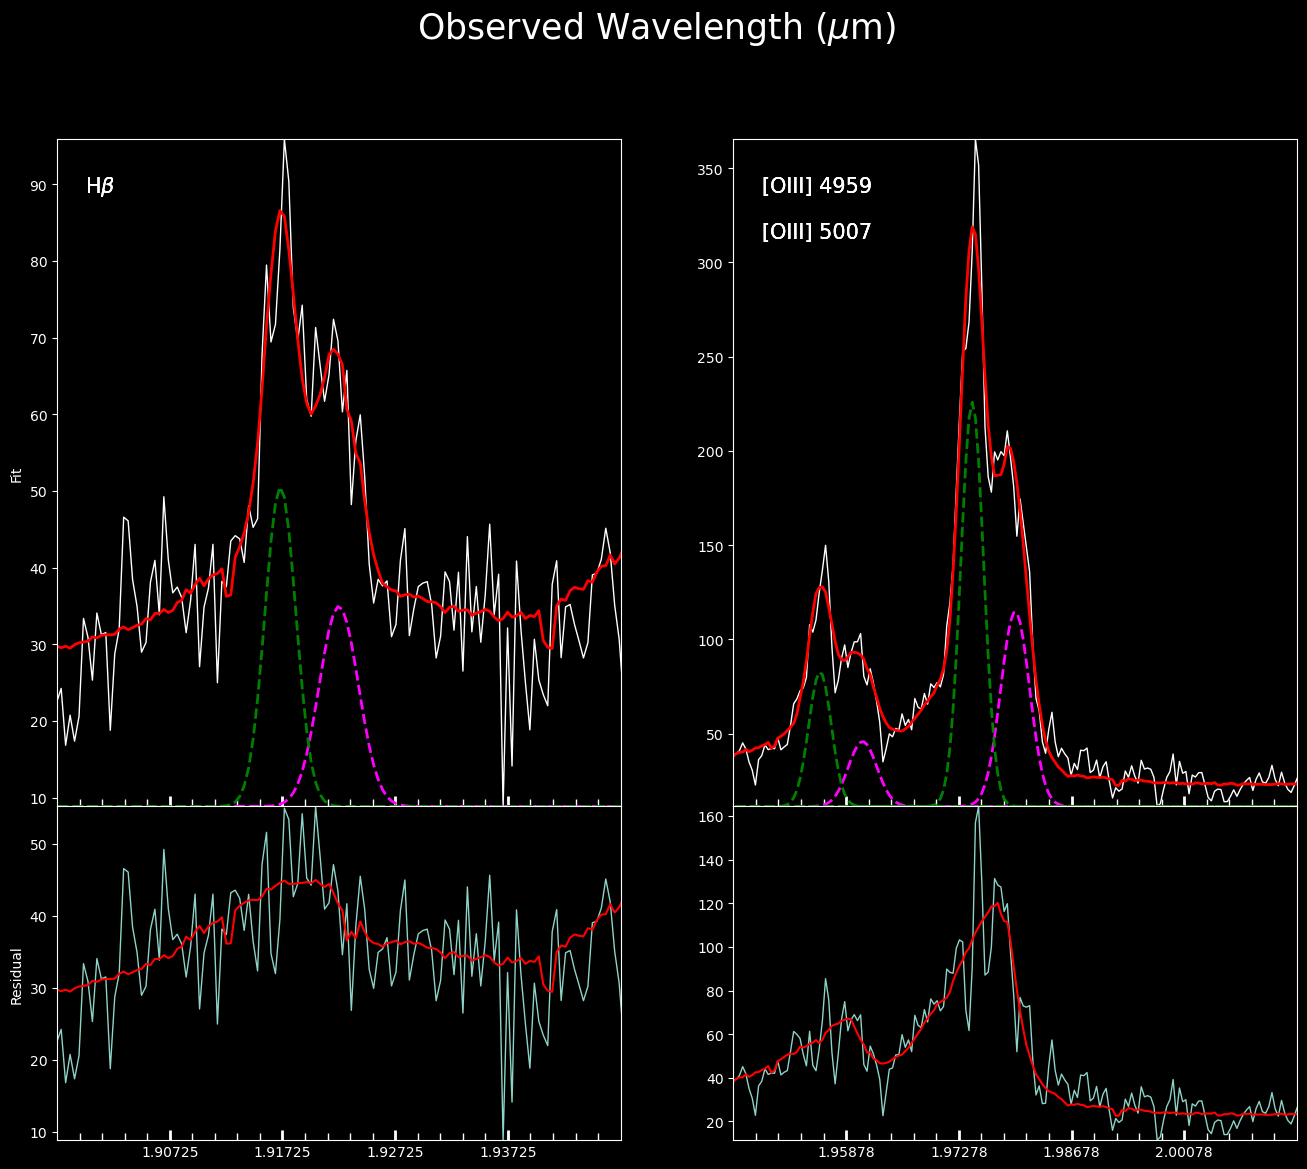

In [35]:
q3do.plot_line(q3di,plotargs=argsplotline)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength.

In [36]:
argscontplot = dict()
argscontplot['xstyle'] = 'lin'
argscontplot['ystyle'] = 'lin'
argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

Because we specified `decompose_qso_fit=True` in the `q3di` object, three plots are created: one for the host-only light, one for quasar-only light, and one for the total continuum.

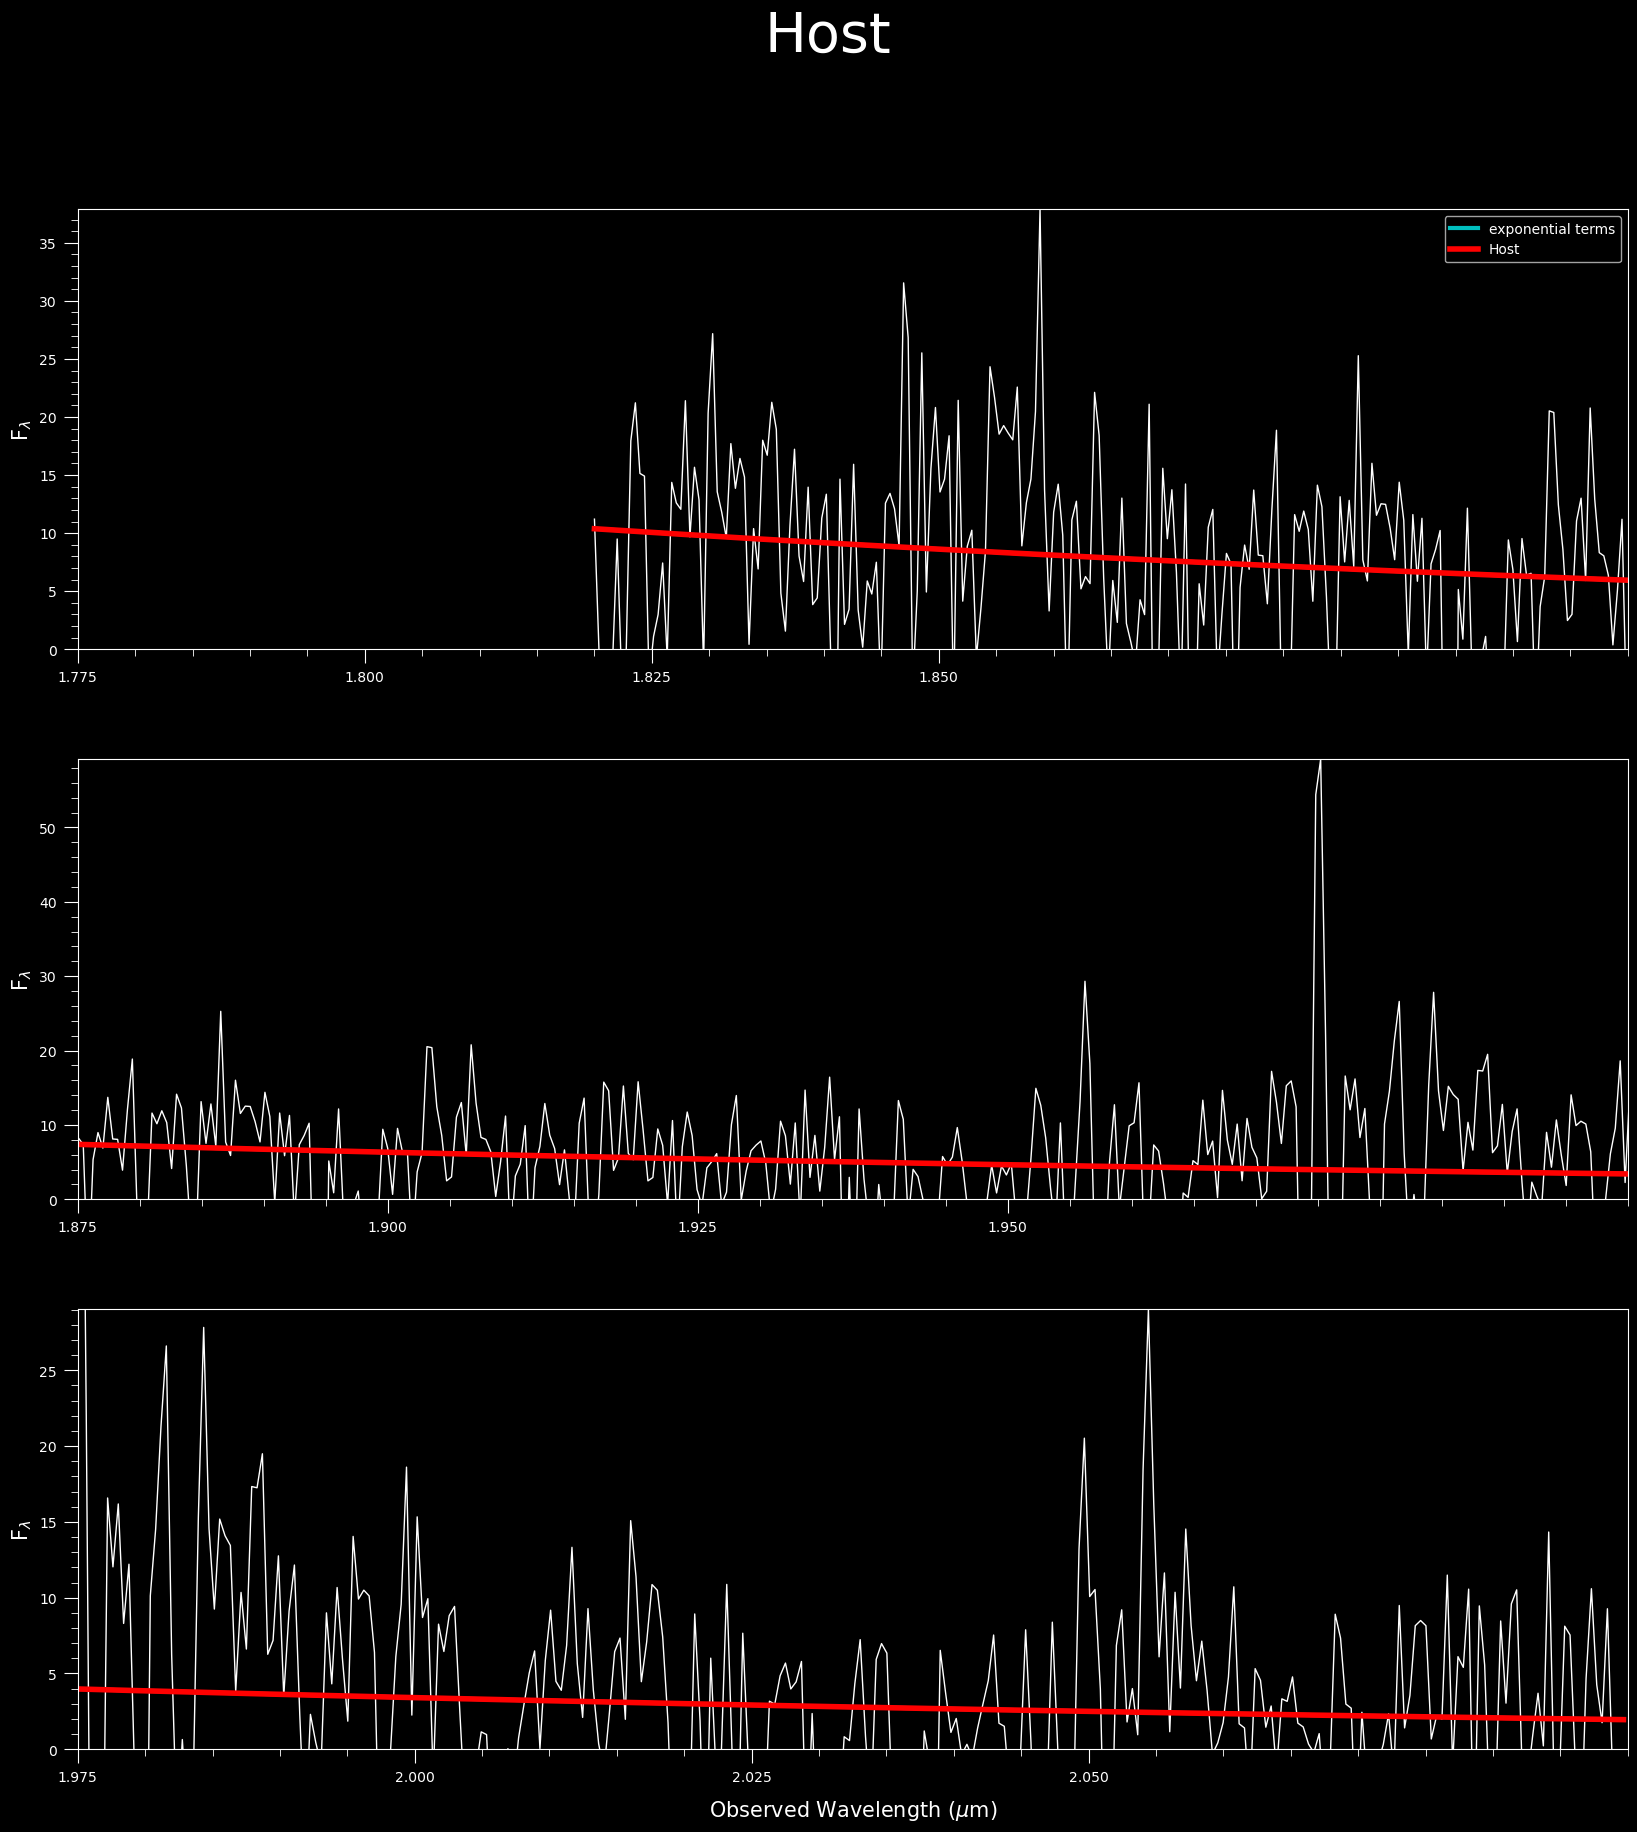

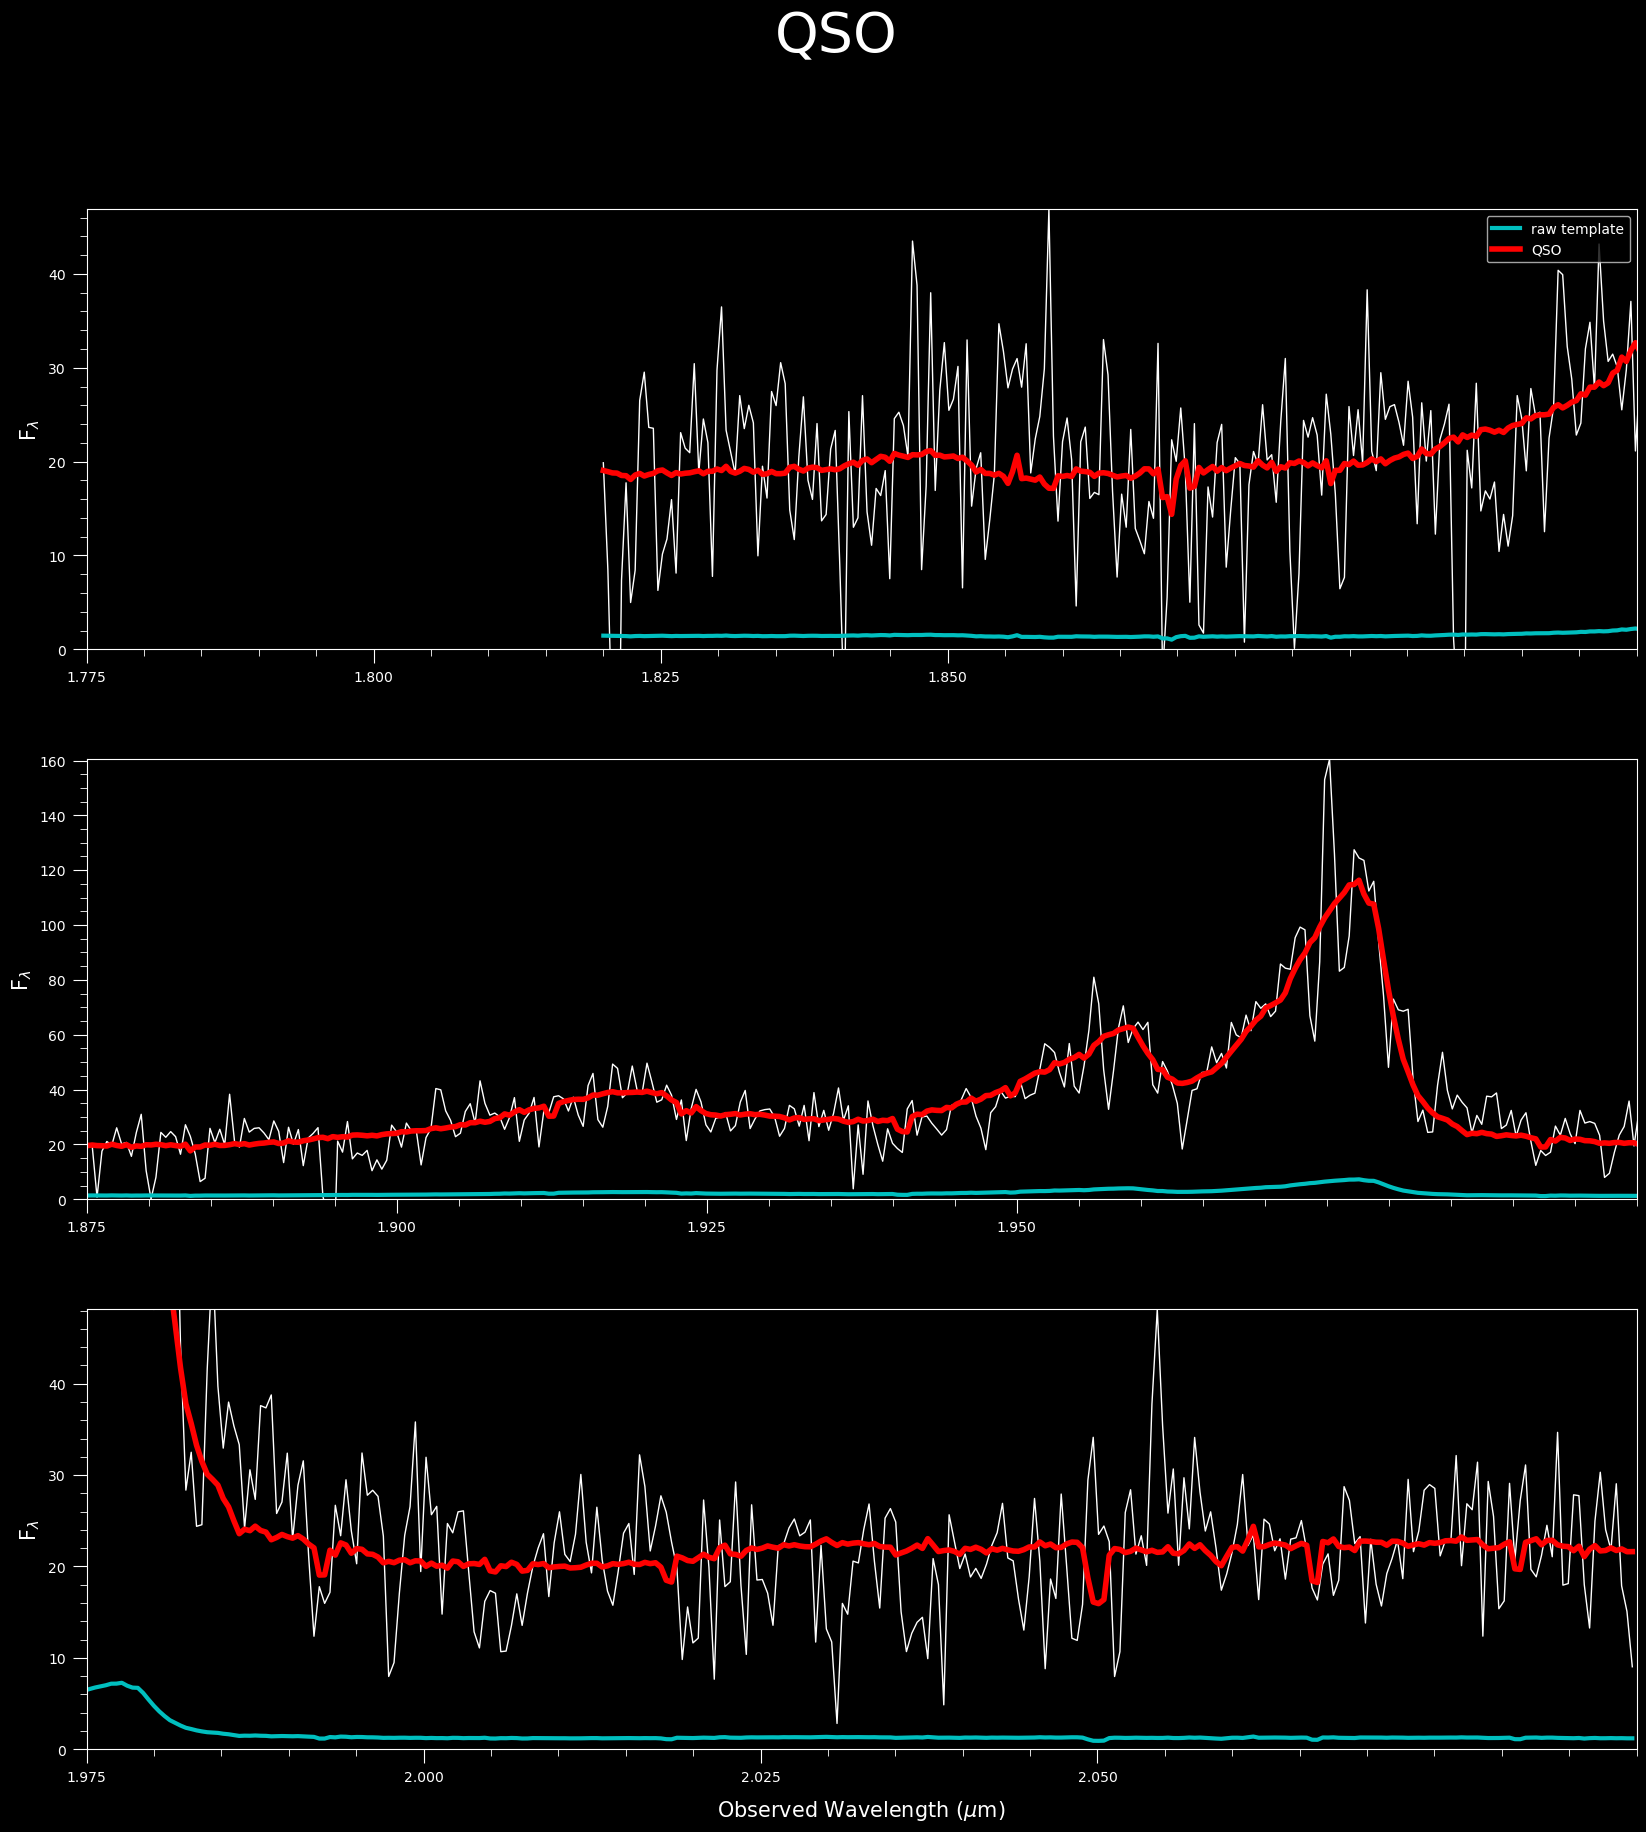

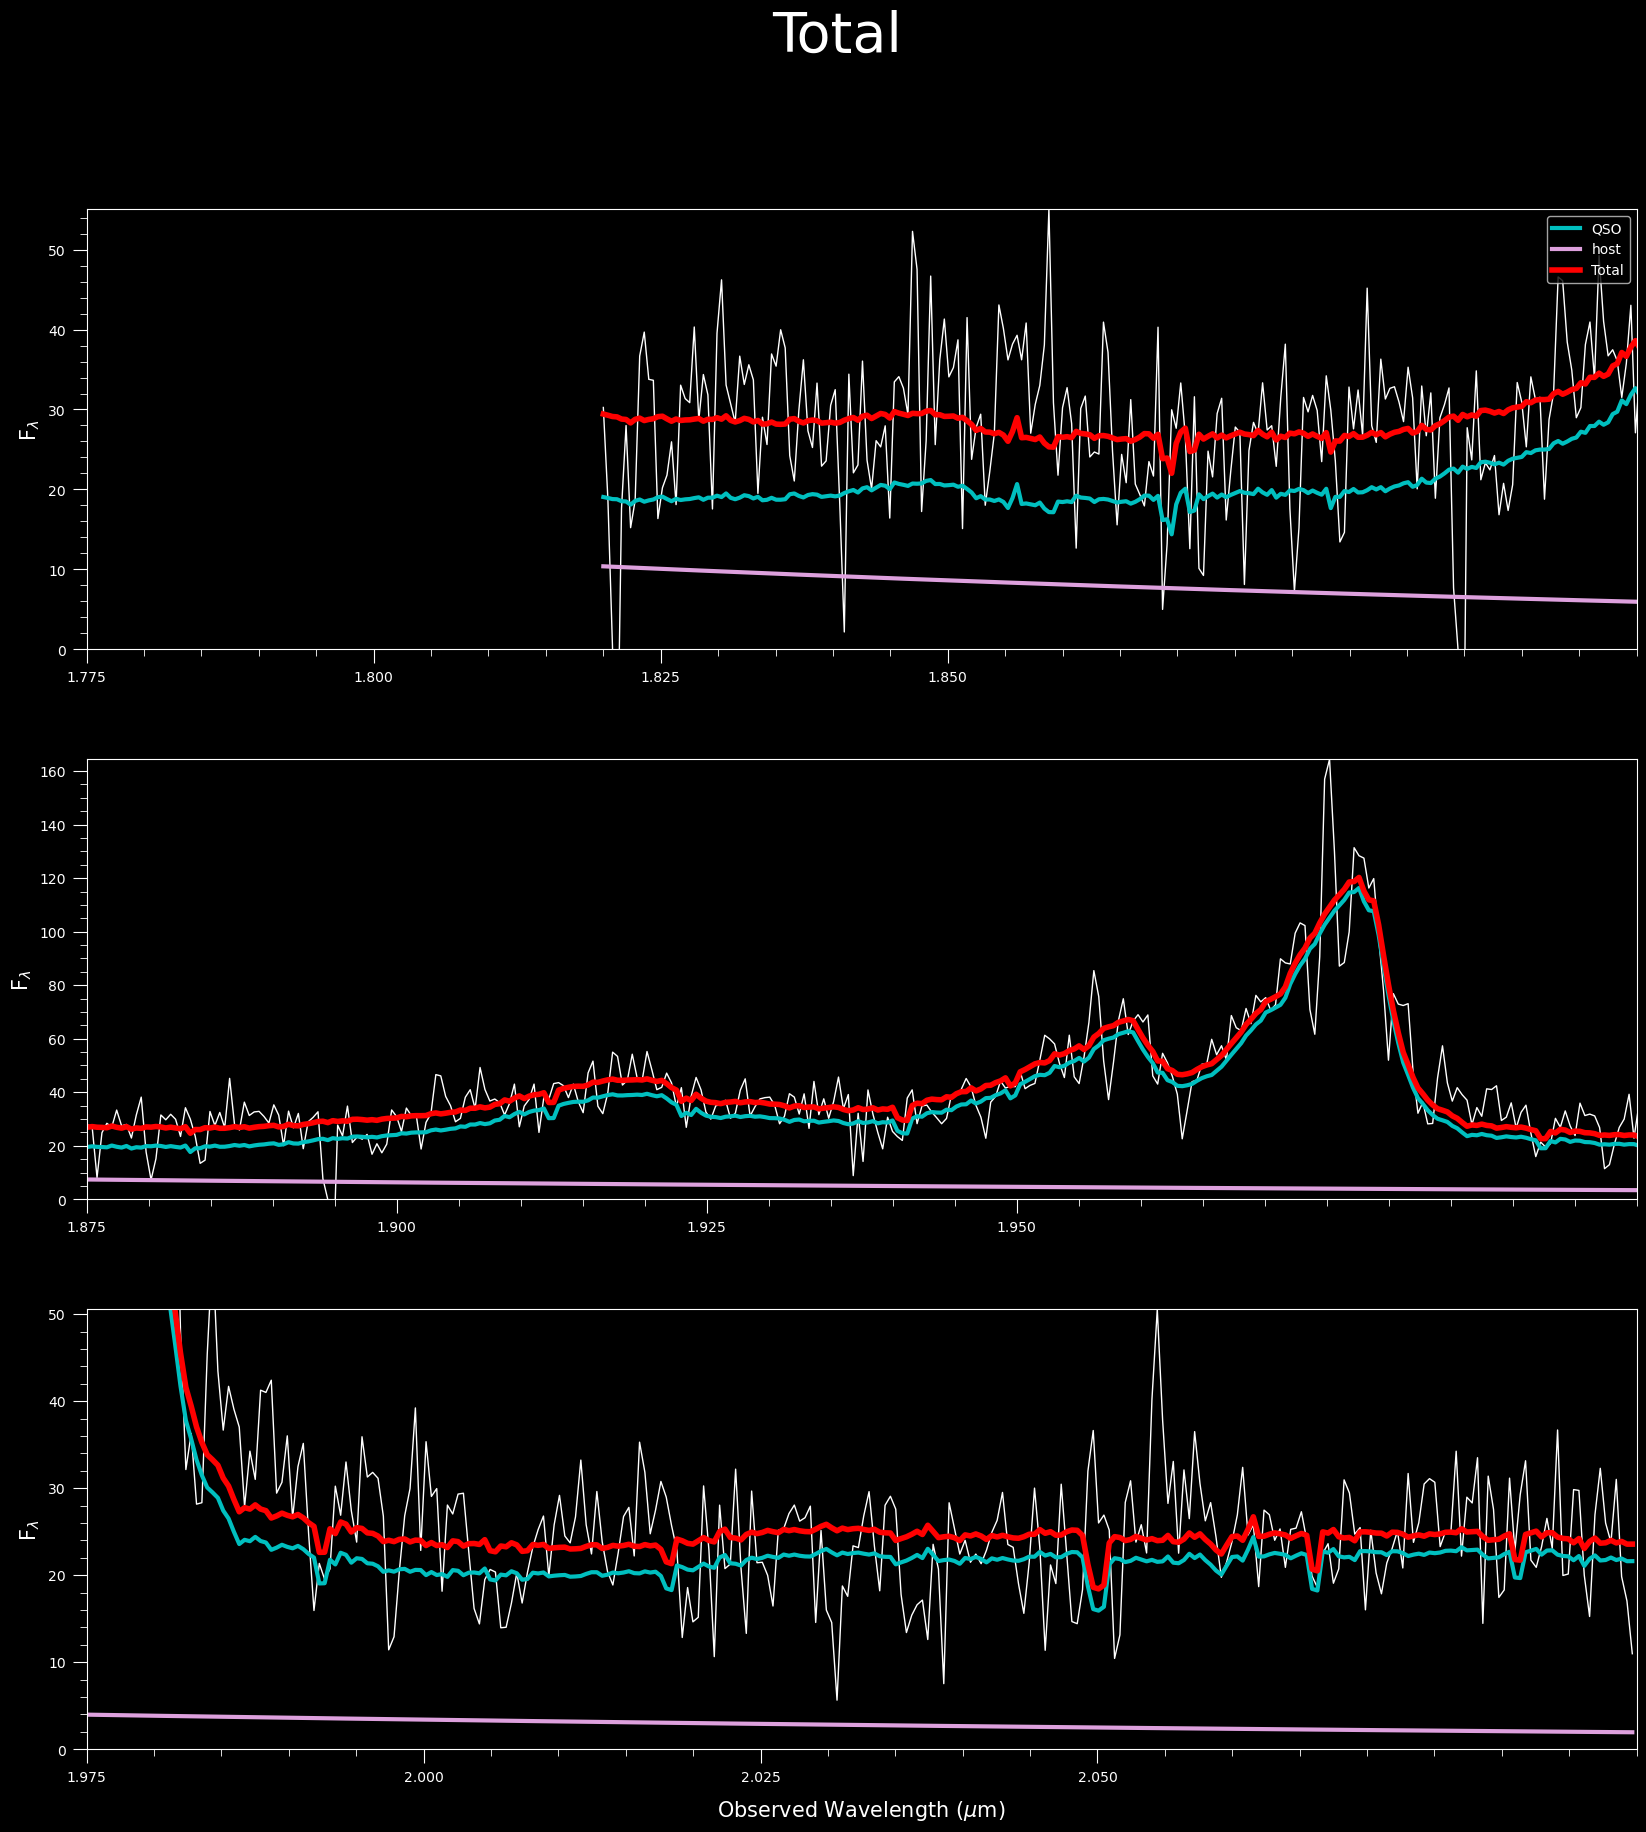

In [37]:
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

## 4. Combine fit results from all spaxels.<a class="anchor" id="chapter4"></a>

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files. This example assumes that the spaxels listed here in each dimension have been fit.

In [38]:
cols = [20, 75]
rows = [15, 70]
from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows)

Sorting components by sigma in the upward direction.
q3dcollect: Saving emission-line fit results into nirspec-j1652/j1652.line.npz
q3dcollect: Saving continuum fit results into nirspec-j1652/j1652.cont.npy


## 5. Plot science products. <a class="anchor" id="chapter5"></a>

These routines take the output of `q3dcollect` and process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [39]:
import q3dfit.q3dpro as q3dpro
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.025, NOCONT=True)

Start by plotting linemaps for [OIII], of both flux and velocity measures. The parameters listed below control the plotting.

Plotting emission line maps
getting line data... [OIII]5007


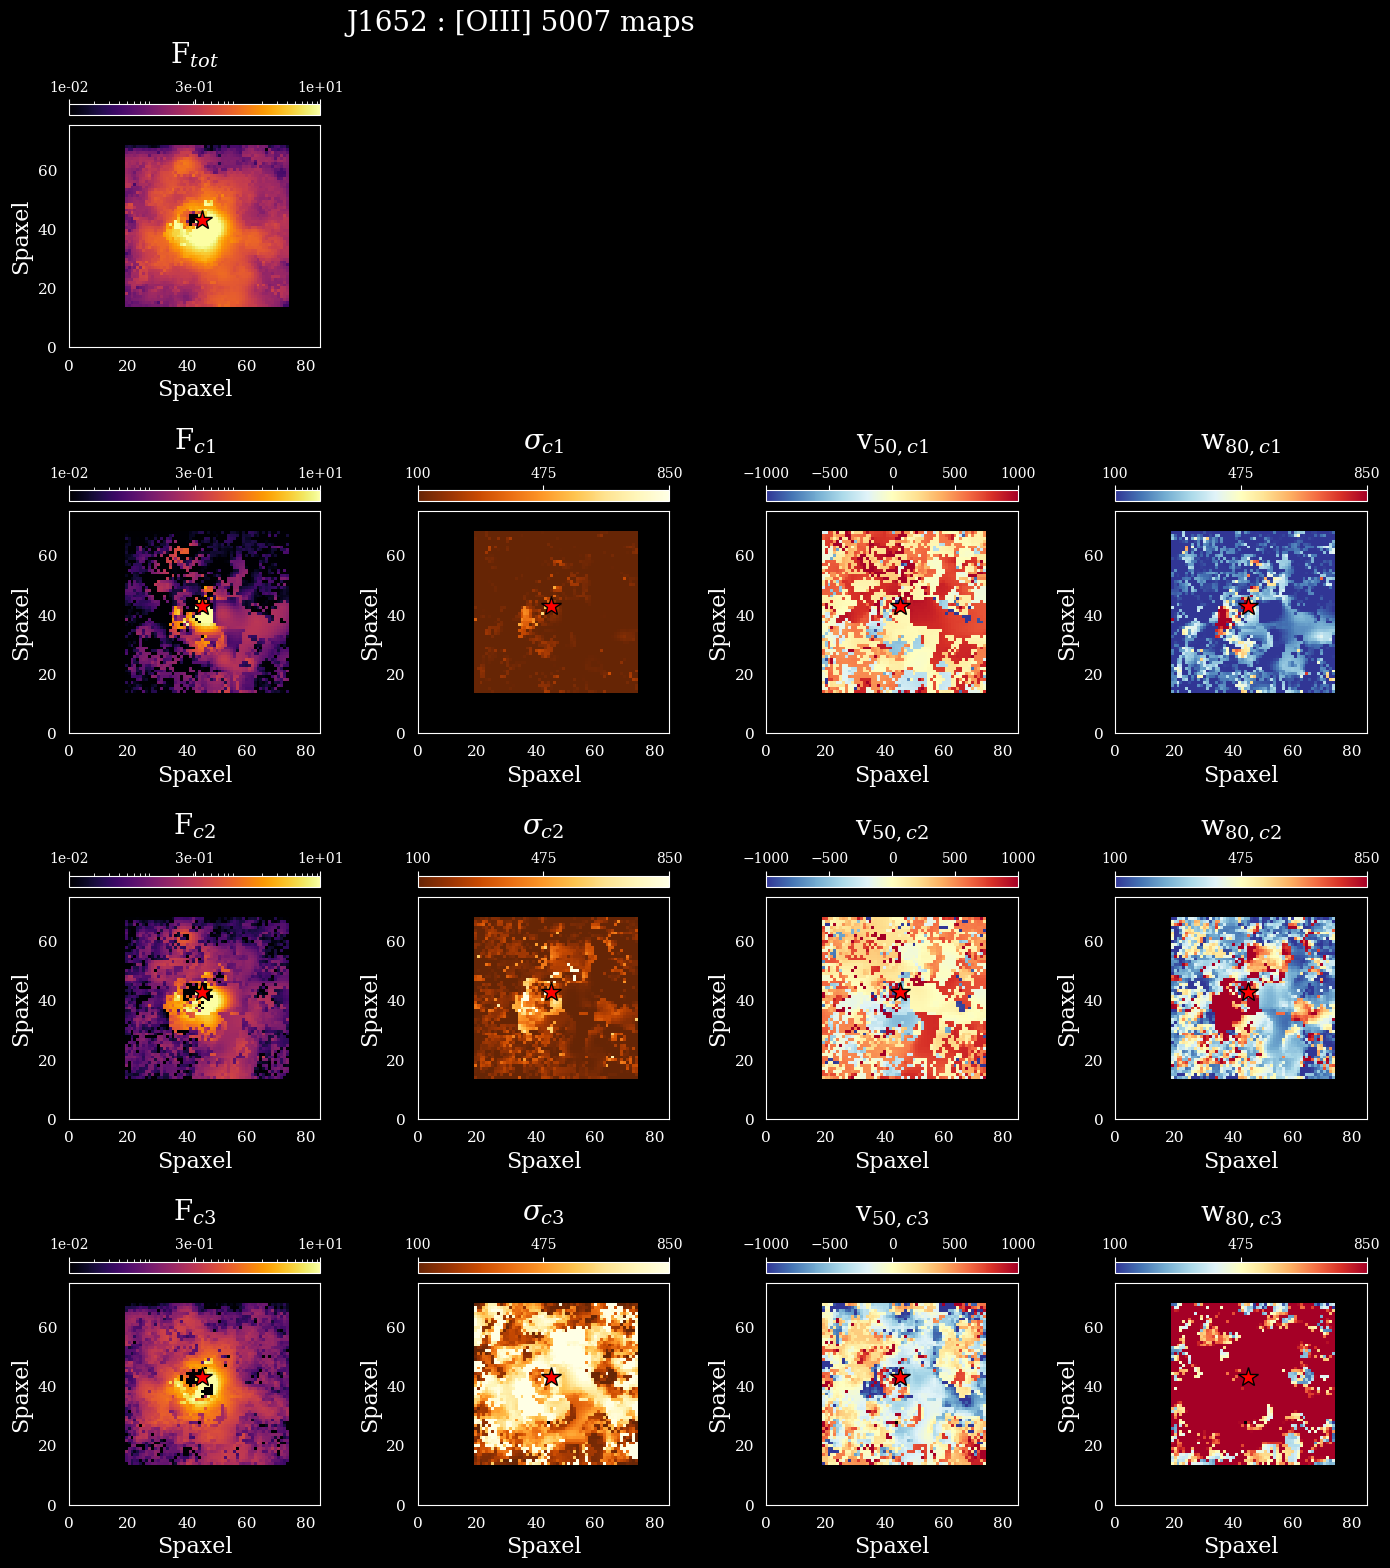

In [40]:
do_kpc = False
saveFile = False
flx = [1e-2,1e1]
qsocenter = [45., 43.]
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[100.,850.],
          'v50':[-1000.,1000.],
          'w80':[100.,850.],
          'fluxlog': True}
qpro.make_linemap('[OIII]5007', XYSTYLE=do_kpc, xyCenter=qsocenter,
                  SAVEDATA=saveFile, VMINMAX=pltarg, PLTNUM=1, CMAP='inferno')

Map of [OIII]/H$\beta$ for each component, and for the total flux:

getting line data... Hbeta
getting line data... [OIII]5007
calculating line ratios...


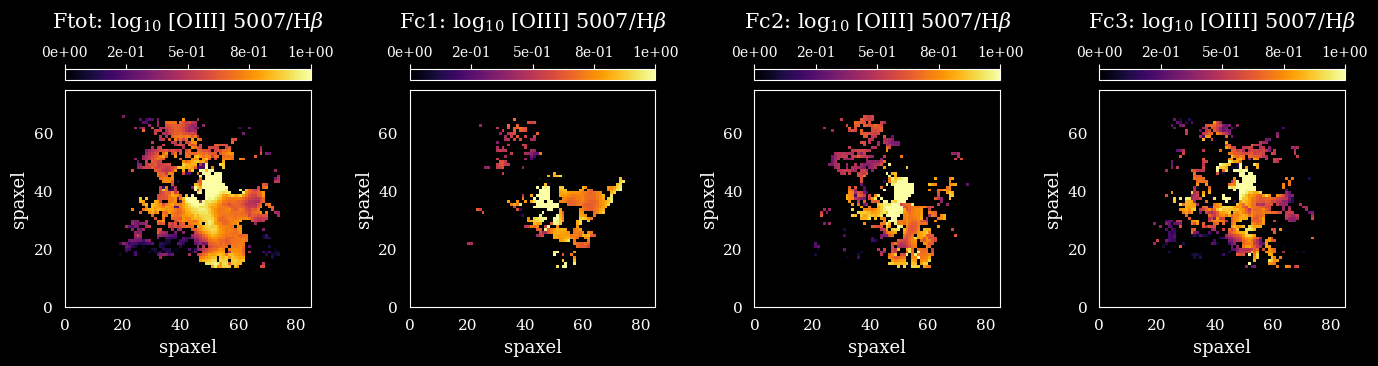

In [41]:
qpro.make_lineratio_map('[OIII]5007', 'Hbeta', VMINMAX=[0,1])

Map of v50 over the cumulative velocity distribution:

Saving  J1652-[OIII]5007-v50-map  to  nirspec-j1652/


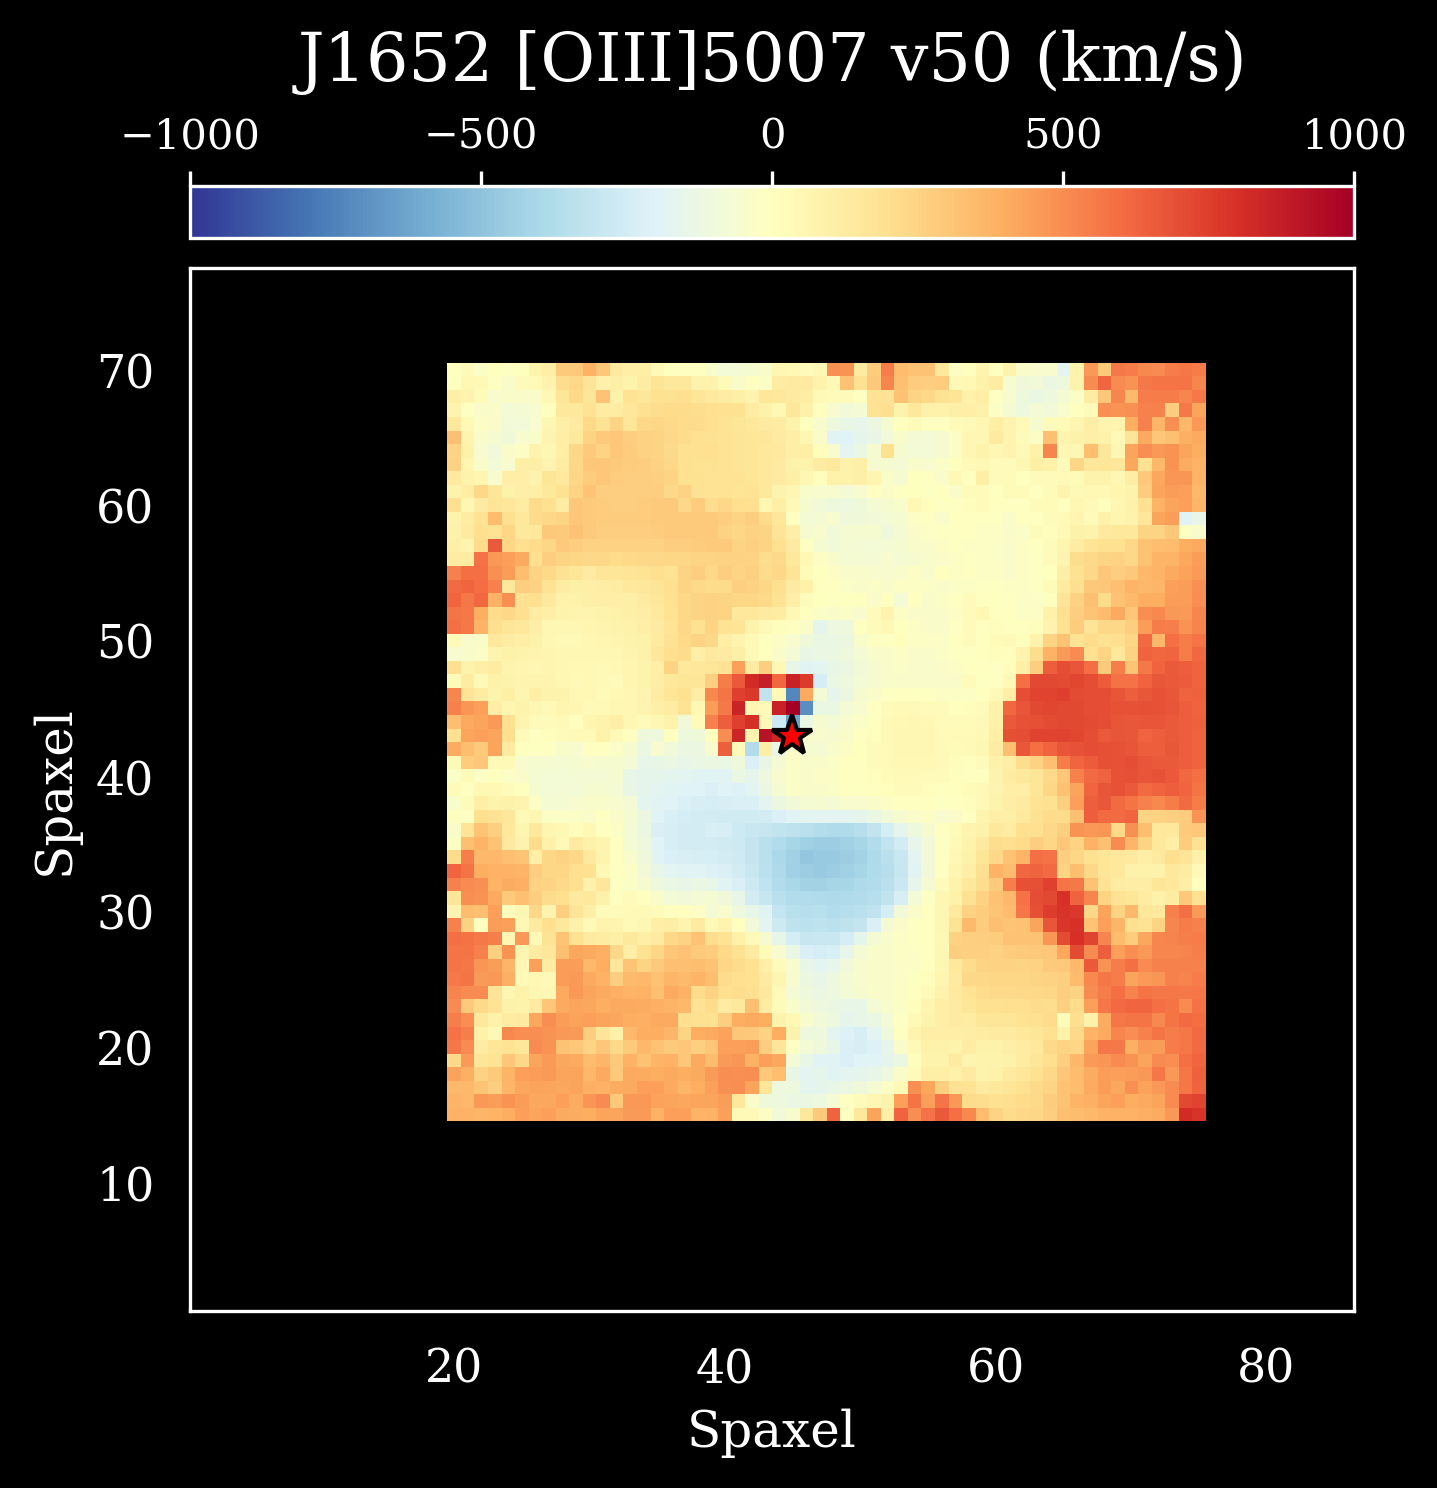

In [42]:
from q3dfit.q3dpro import OneLineData
o3data = OneLineData(qpro.linedat, '[OIII]5007')
o3data.calc_cvdf(2.9489, [-1e3, 1e3], vstep=5)
o3data.make_cvdf_map(50., velran=[-1e3, 1e3], markcenter=[45., 43.],
                     outfile=True)

Map of W80 over the cumulative velocity distribution:

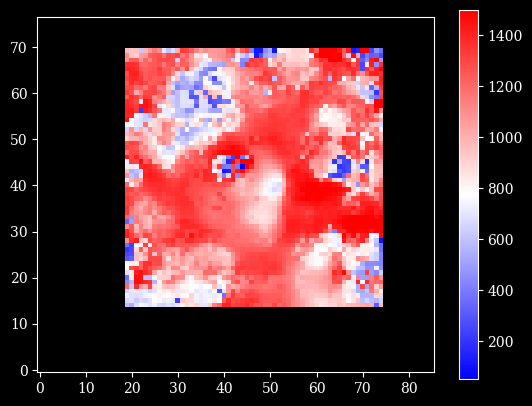

In [43]:
from matplotlib.pyplot import *
imshow(o3data.calc_cvdf_vel(90, calc_from_posvel=False).T - o3data.calc_cvdf_vel(10, calc_from_posvel=False).T, 
       origin='lower', cmap='bwr', vmin=50, vmax=1500)
colorbar()